In [88]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import numpy as np
from netCDF4 import Dataset, num2date
import cartopy.feature as cf
import GOES
import tensorflow as tf
import re
from datetime import datetime, timedelta

In [89]:
def crearModelo2D(p,run):    
    print(f"Creadno modelo con input ({p['margen'][run]},{p['margen'][run]},{p['canales'][run]})) tipo ({p['outputs']})")
    # Imagen
    input_1 = tf.keras.layers.Input(shape=(p['margen'][run],p['margen'][run],p['canales'][run]))
    
    # Convulutional layers
    rescaling = tf.keras.layers.Rescaling(1./65536)(input_1)
    conv2d_1 = tf.keras.layers.Conv2D(128, kernel_size=3,activation=tf.keras.activations.relu)(rescaling)
    mxPool_1 = tf.keras.layers.MaxPooling2D()(conv2d_1)
    dropout_1  = tf.keras.layers.Dropout(0.2)(mxPool_1)
    
    conv2d_2 = tf.keras.layers.Conv2D(64, kernel_size=3,activation=tf.keras.activations.relu)(dropout_1)
    mxPool_2 = tf.keras.layers.MaxPooling2D()(conv2d_2)
    dropout_2  = tf.keras.layers.Dropout(0.1)(mxPool_2)
    
    conv2d_3 = tf.keras.layers.Conv2D(32, kernel_size=3,activation=tf.keras.activations.relu)(dropout_1)
    mxPool_3 = tf.keras.layers.MaxPooling2D()(conv2d_3)
    dropout_3  = tf.keras.layers.Dropout(0.2)(mxPool_3)
    
    conv2d_4 = tf.keras.layers.Conv2D(64, kernel_size=3,activation=tf.keras.activations.relu)(dropout_3)
    mxPool_4 = tf.keras.layers.MaxPooling2D()(conv2d_4)
    dropout_4  = tf.keras.layers.Dropout(0.2)(mxPool_4)
    
    conv2d_5 = tf.keras.layers.Conv2D(32, kernel_size=3,activation=tf.keras.activations.relu)(dropout_4)
    
    
    # Flatten layer :
    flatten = tf.keras.layers.Flatten()(conv2d_5)
    
    final = flatten
    listConcat = [flatten]
    listInputs = [input_1]
    
    if len(p['inputs'])>1:
        #Agregamos los otros atrbutos        
        for attr in p['inputs'][1:]:
            # The other input
            input_x = tf.keras.layers.Input(shape=(1,))
            listConcat.append(input_x)
            listInputs.append(input_x)

            
        # Concatenate
        final = tf.keras.layers.Concatenate()(listConcat)
        
    dense_1 = tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu)(final)
    dense_2 = tf.keras.layers.Dense(units=16, activation=tf.keras.activations.relu)(dense_1)
    dense_3 = tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu)(dense_2)
    
        
    # output
    if p['outputs'] == 'dato':
        output = tf.keras.layers.Dense(units=1)(dense_3)
        dimOutput = 1
    elif p['outputs'] == 'umbral':
        output = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)(dense_3)
        dimOutput = 2
    else:
        print(f"No se pudo crear el modelo outputs no esta bien definido {p['outputs']}")
        return -1      
    

    full_model = tf.keras.Model(inputs=listInputs, outputs=[output])
    
    print('DONE')
    
    #print(full_model.summary())
    return full_model

In [90]:
def dibujar(lons,lats,field,mersh=0):
    
    if mersh:
        #field=  np.resize(f,(len(lats),len(lons)))
        lons, lats = np.meshgrid(lons, lats)  
    else:
        field = field
    
    # realiza el grafico
    fig = plt.figure('ABI', figsize=(4,4), dpi=150)
    ax = fig.add_axes([0.1,0.1,0.8,0.8], projection=ccrs.PlateCarree())
    ax.add_feature(cf.COASTLINE)
    ax.add_feature(cf.BORDERS)
    img = ax.pcolormesh(lons, lats, field, cmap=plt.cm.Greys, transform=ccrs.PlateCarree())
    plt.colorbar(img)    
    plt.show()    
    return 

In [63]:

strA = 'OR_ABI-L2-CMIPF-M6C07_G16_s20200320200017.nc'
canal = '07'
times = ['10','20','30','40','50','00']

maths = re.findall(r'OR_ABI-L2-CMIPF-M6C07_G16_s(.*).nc', strA)
tiempo = converGoesDate(maths[0][1],reversa=True)

newName = f'{canal}_{tiempo}.nc'

'2020-03-20-20-00'

In [93]:
def procesarImagen(file,canal,pos,fecha): 
    domain = [-83.5495, -66.4504, -20.2252, 1.3783]
    ds = GOES.open_dataset(file)    
    CMI, LonCor, LatCor = ds.image('CMI', lonlat='corner', domain=domain)    

In [82]:
def converGoesDate(fecha, hh=0, mm=0, reversa=False):
    if reversa:
        return fecha[0:4] + '-' + fecha[4:6] + '-' + fecha[6:8] + '-' + fecha[8:10] + '-' + fecha[10:12]
    else:
        f = datetime.strptime(tiempo, "%Y-%m-%d-%H-%M") + timedelta(hours=hh, minutes=mm)  
        return f'{f.year:04}{f.month:02}{f.day:02}-{f.hour:02}{f.minute:02}00'    

In [94]:
def downloadImageGOES(fechas,canales,tiempos):
    if not fechas:
        print("Debe especificar fechas")
        return -1
    
    domain = [-83.5495, -66.4504, -20.2252, 1.3783]
    errors = []
    for fecha in fechas:
        # 2020 - 02 - 23 - 12 - 00
        
        newName = f'./Imagenes/{fecha}.nc'
        f = nc4.Dataset(newName,'w', format='NETCDF4')          
        
        fechaIni = converGoesDate(fecha, hh=-1, mm=10)
        fechaFin = converGoesDate(fecha, mm=10)
          
        for c in canales:
            filesT = GOES.download('goes16', 'ABI-L2-CMIPF',
                     DateTimeIni = fechaIni, DateTimeFin = fechaFin, 
                     channel = [c] , rename_fmt = '%Y%m%d%H%M%S', path_out='./Temp/')
                                    
            result =  comprobarTiempos(fielsT,tiempos) 
            
            for i in range(len(filesT)):                
                
                ds = GOES.open_dataset(file)    
                CMI, LonCor, LatCor = ds.image('CMI', lonlat='corner', domain=domain)  
                CMI = (CMI*1000).astype(np.int16)
                
                tmpGroup = f.createGroup(f'{c}-{tiempos[i]}')
                tmpGroup.createDimension('longitude', LonsCen.shape[1])
                tmpGroup.createDimension('latitude', LatsCen.shape[0])          
                
                lats_file = dataset.createVariable('latitude', LatCor.dtype.type, ('latitude',))
                lons_file = dataset.createVariable('longitude', lonCor.dtype.type, ('longitude',))                
                parameter01 = dataset.createVariable('CMI', CMI.dtype.type, ('latitude', 'longitude'), zlib=True) #, least_significant_digit=2)
                
                lats_file[:] = LatsCen[:,0]
                lons_file[:] = LonsCen[0,:]
                parameter01[:,:] = Field
                
        f.close()   
                    
    return errors

In [ ]:
def getMatrizImage(canales,tiempos,fecha):
    listFile = downloadImageGOES(fecha,canales,tiempos)
    

In [24]:
matrices

['./Temp/OR_ABI-L2-CMIPF-M6C07_G16_s20200320200017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C07_G16_s20200320201017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C07_G16_s20200320202017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C07_G16_s20200320203017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C07_G16_s20200320204017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C07_G16_s20200320205017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C08_G16_s20200320200017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C08_G16_s20200320201017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C08_G16_s20200320202017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C08_G16_s20200320203017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C08_G16_s20200320204017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C08_G16_s20200320205017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C13_G16_s20200320200017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C13_G16_s20200320201017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C13_G16_s20200320202017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C13_G16_s20200320203017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C13_G16_s20200320204017.nc',
 './Temp/OR_ABI-L2-CMIPF-M6C13_G16_s202003202050

In [23]:
canales = ['07','08','13']
tiempos   = ['00','50','40','30','20','10']

matrices = getMatrizImage(canales,tiempos,'2020-03-20-20')

20200320-200000
Files:
  OR_ABI-L2-CMIPF-M6C07_G16_s20200320200017.nc 100% 26.3MB 4s
  OR_ABI-L2-CMIPF-M6C07_G16_s20200320201017.nc 100% 26.2MB 4s
  OR_ABI-L2-CMIPF-M6C07_G16_s20200320202017.nc 100% 26.2MB 4s
  OR_ABI-L2-CMIPF-M6C07_G16_s20200320203017.nc 100% 26.1MB 5s
  OR_ABI-L2-CMIPF-M6C07_G16_s20200320204017.nc 100% 26.0MB 14s
  OR_ABI-L2-CMIPF-M6C07_G16_s20200320205017.nc 100% 26.0MB 5s
  OR_ABI-L2-CMIPF-M6C08_G16_s20200320200017.nc 100% 19.7MB 3s
  OR_ABI-L2-CMIPF-M6C08_G16_s20200320201017.nc 100% 19.7MB 3s
  OR_ABI-L2-CMIPF-M6C08_G16_s20200320202017.nc 100% 19.7MB 5s
  OR_ABI-L2-CMIPF-M6C08_G16_s20200320203017.nc 100% 19.7MB 4s
  OR_ABI-L2-CMIPF-M6C08_G16_s20200320204017.nc 100% 19.7MB 4s
  OR_ABI-L2-CMIPF-M6C08_G16_s20200320205017.nc 100% 19.7MB 7s
  OR_ABI-L2-CMIPF-M6C13_G16_s20200320200017.nc 100% 27.1MB 5s
  OR_ABI-L2-CMIPF-M6C13_G16_s20200320201017.nc 100% 27.1MB 5s
  OR_ABI-L2-CMIPF-M6C13_G16_s20200320202017.nc 100% 27.1MB 4s
  OR_ABI-L2-CMIPF-M6C13_G16_s20200320203017.nc

In [65]:
import GOES
fielsT = GOES.download('goes16', 'ABI-L2-CMIPF',
             DateTimeIni = '20200320-201000', DateTimeFin = '20200320-211000', 
             channel = ['13'], rename_fmt = '%Y%m%d%H%M%S', path_out='./Temp/')

Files:
  OR_ABI-L2-CMIPF-M6C13_G16_s20200320201017.nc 100% 27.1MB 3s
  OR_ABI-L2-CMIPF-M6C13_G16_s20200320202017.nc 100% 27.1MB 3s
  OR_ABI-L2-CMIPF-M6C13_G16_s20200320203017.nc 100% 27.0MB 3s
  OR_ABI-L2-CMIPF-M6C13_G16_s20200320204017.nc 100% 27.0MB 3s
  OR_ABI-L2-CMIPF-M6C13_G16_s20200320205017.nc 100% 27.0MB 4s
  OR_ABI-L2-CMIPF-M6C13_G16_s20200320210017.nc 100% 27.0MB 3s


In [84]:
#Para un conjunto de estaciones (dataframe), agrega su posicion XO(longitud), XA(latitud)

#Como input recibe un string que es el directoeio de una imagen satelital (.nc),
#devuelve la matriz que representa esta imagen numpy.array(1200,950)
def getMapFile(imagenFile,mersh=0,imprimir=0):    
    try:
        ds = Dataset(imagenFile)      
    except:
        print("No se pudo leer los archivos de imagen")
        print(imagenFile)
        return -1,-1

    # convierte el formato de la variable de Int16 a Float32 y guarda el resultado
    field = ds.variables['CMI'][:].data.astype(np.float32)/100.0

    # obtiene las coordenadas de los pixeles
    lons = ds.variables['longitude'][:].data
    lats = ds.variables['latitude'][:].data
    if imprimir:
        dibujar(lons,lats,field,mersh)
        
    return lons, lats , field
    
    

In [85]:
path_base = 'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Codigo/Deploy/ImagesTemp/'
imagenTest = 'D:/GOES/C13/2020/03/G16_C13_Cyl_20200320-2000.nc'

In [86]:
len(fielsT)

6

In [87]:
# set the map domain
#domain = [-90.0,-60.0,-20.0,2.0]
domain = [x.min(),x.max(),y.min(),y.max()]

#domain = [-88.0,-63.0,-25.0,5.0] #[-90.0,-30.0,-60.0,15.0]
xmin, xmax = 80, 1030 # -83.54954954954955 -66.45045045045045
ymin, ymax = 700, 1900 # -20.225225225225227 1.3783783783783794

# reads the file
#ds =  Dataset(fielsT[0])
ds = GOES.open_dataset(fielsT[0])

# get image with the coordinates of corners of their pixels
CMI, LonCor, LatCor = ds.image('CMI', lonlat='corner', domain=domain)

# get information about data
sat = ds.attribute('platform_ID')
band = ds.variable('band_id').data[0]

NameError: name 'x' is not defined

In [91]:
x,y,c = getMapFile(imagenTest)

In [92]:
domain = [x.min(),x.max(),y.min(),y.max()]
domain

[-83.54954954954955,
 -66.45045045045045,
 -20.225225225225227,
 1.3783783783783794]

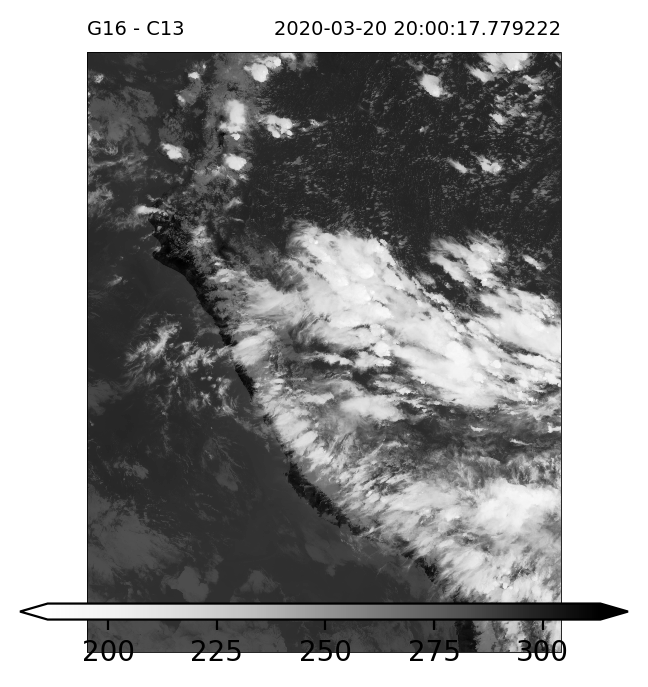

In [76]:
# calculates the central longitude of the plot
lon_cen = 360.0+(domain[0]+domain[1])/2.0

# creates the figure
fig = plt.figure('map', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.16, 0.80, 0.75], projection=ccrs.PlateCarree(lon_cen))
ax.outline_patch.set_linewidth(0.3)

# add the geographic boundaries
l = NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax.add_feature(l, edgecolor='gold', linewidth=0.25)

# plot the data
img = ax.pcolormesh(LonCor.data, LatCor.data, CMI.data, cmap=plt.cm.Greys, transform=ccrs.PlateCarree())

# add the colorbar
cb = plt.colorbar(img, orientation='horizontal', extend='both', cax=fig.add_axes([0.12, 0.2, 0.76, 0.02]))

# set the title
ax.set_title('{} - C{}'.format(sat, band), fontsize=7, loc='left')
ax.set_title(CMI.time_bounds.data[0], fontsize=7, loc='right')

# set the map limits
ax.set_extent([domain[0]+360.0, domain[1]+360.0, domain[2], domain[3]], crs=ccrs.PlateCarree())

plt.show()

Text(0.5, 1.0, 'ASD')

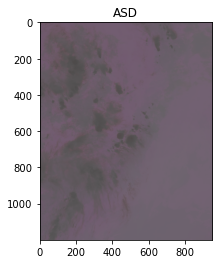

In [106]:
filename = f'F:/GOES/PNG/2020-01-01-03/2020-01-01-03_1.png'
image_string = tf.io.read_file(filename)
img_decoded = tf.io.decode_png(image_string, dtype=tf.uint8, channels=3)


resize_and_rescale = tf.keras.Sequential([
  #layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

data_augmentation = tf.keras.Sequential([
  
])

img_decoded = tf.image.flip_left_right(img_decoded)

#img_decoded = resize_and_rescale(img_decoded)
#img_decoded = data_augmentation(img_decoded)

plt.imshow(img_decoded)
plt.title('ASD')